In [ ]:
 import tensorflow as tf
 import numpy as np
 import matplotlib.pyplot as plt
 import tensorflow_datasets as tfds
 import cv2
 import tensorflow_probability as tfp

 from tensorflow.keras.layers import Resizing,Rescaling,InputLayer, Dense, Conv2D,MaxPooling2D
 from tensorflow.keras.layers import Permute,Embedding, LayerNormalization,MultiHeadAttention, Flatten, BatchNormalization, Input, Dropout, GlobalAveragePooling2D
 from tensorflow.keras.layers import Add, Activation, RandomRotation,RandomFlip,RandomContrast
 from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
 from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy
 from tensorflow.keras.optimizers import Adam
 from tensorflow.keras.models import Model
 from tensorflow.keras.layers import Layer
 from tensorflow.keras.regularizers import L2,L1

 from tensorflow.train import BytesList, FloatList, Int64List
 from tensorflow.train import Example, Features, Feature
 import sklearn
 from sklearn.metrics import confusion_matrix, roc_curve
 import seaborn as sns

 from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
# install kaggle to download the dataset from kaggle
!pip install -q kaggle

In [ ]:
# kaggle.json is a api token used to give access to the user
# store the kaggle.json file in ~/.kaggle directory to allow the use of api token
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
# Give user the full right to read and write into the kaggle file
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# downloading the casting defects datasets from kaggle
!kaggle datasets download -d ravirajsinh45/real-life-industrial-dataset-of-casting-product

 80% 80.0M/100M [00:00<00:00, 168MB/s]
100% 100M/100M [00:00<00:00, 156MB/s] 


In [ ]:
# Unzip the data and save into a dataset folder
!unzip "/content/real-life-industrial-dataset-of-casting-product.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/casting_data/casting_data/train/def_front/cast_def_0_5259.jpeg  
  inflating: /content/dataset/casting_data/casting_data/train/def_front/cast_def_0_526.jpeg  
  inflating: /content/dataset/casting_data/casting_data/train/def_front/cast_def_0_5260.jpeg  
  inflating: /content/dataset/casting_data/casting_data/train/def_front/cast_def_0_5262.jpeg  
  inflating: /content/dataset/casting_data/casting_data/train/def_front/cast_def_0_5265.jpeg  
  inflating: /content/dataset/casting_data/casting_data/train/def_front/cast_def_0_527.jpeg  
  inflating: /content/dataset/casting_data/casting_data/train/def_front/cast_def_0_5270.jpeg  
  inflating: /content/dataset/casting_data/casting_data/train/def_front/cast_def_0_5272.jpeg  
  inflating: /content/dataset/casting_data/casting_data/train/def_front/cast_def_0_5274.jpeg  
  inflating: /content/dataset/casting_data/casting_data/train/def_front/cast_def_0_528.jpeg  
  

In [ ]:
train_directory = "/content/dataset/casting_data/casting_data/train"
val_directory = "/content/dataset/casting_data/casting_data/test"

CLASS_NAMES = ["def_front", "ok_front"]

# Dictionary "Configuration" describing the parameters for the model
Configuration = {
    "Batch_size" : 32,
    "Im_size"    : 256,
    "learning_rate" : 0.001,
    "n_epochs" : 50,
    "num_classes": 2,
    "patch_size": 16,
}

In [ ]:
# Creating the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode= 'categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=Configuration["Batch_size"],
    image_size=(Configuration["Im_size"], Configuration["Im_size"]),
    shuffle=True,
    seed=66,


)

Found 6633 files belonging to 2 classes.


In [ ]:
#Creating a validation dataset
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=Configuration["Batch_size"],
    image_size=(Configuration["Im_size"], Configuration["Im_size"]),
    shuffle=True,
    seed=66,


)

Found 715 files belonging to 2 classes.


In [ ]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[176.91406, 176.91406, 176.91406],
         [176.91406, 176.91406, 176.91406],
         [176.91406, 176.91406, 176.91406],
         ...,
         [181.39276, 181.39276, 181.39276],
         [181.     , 181.     , 181.     ],
         [181.     , 181.     , 181.     ]],

        [[176.     , 176.     , 176.     ],
         [176.     , 176.     , 176.     ],
         [176.     , 176.     , 176.     ],
         ...,
         [181.     , 181.     , 181.     ],
         [181.     , 181.     , 181.     ],
         [180.76434, 180.76434, 180.76434]],

        [[176.     , 176.     , 176.     ],
         [176.     , 176.     , 176.     ],
         [176.     , 176.     , 176.     ],
         ...,
         [181.     , 181.     , 181.     ],
         [180.68109, 180.68109, 180.68109],
         [180.04901, 180.04901, 180.04901]],

        ...,

        [[138.     , 138.     , 138.     ],
         [137.74219, 137.74219, 137.74219]

**Data visualization**

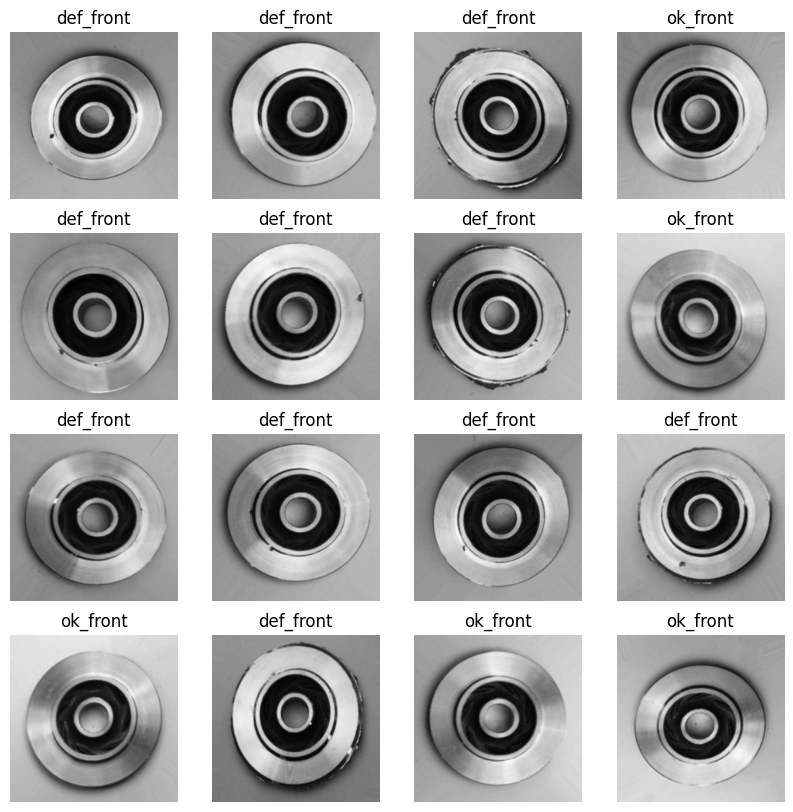

In [ ]:
plt.figure(figsize = (10,10))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.0)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

**Data Augmentation**

In [ ]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.025,0.025)),
    RandomFlip(mode = 'horizontal'),
    RandomContrast(factor = 0.1),

])

In [ ]:
def augment_layer(image,label):
  return augment_layers(image, training=True), label

**Resizing and Rescaling Data**

In [ ]:
def resizing_rescale_images(image, label):
  return tf.image.resize(image, (Configuration["Im_size"], Configuration["Im_size"]))/255.0, label

**Data Preparation**

In [ ]:
train_dataset = train_dataset.map(resizing_rescale_images)
val_dataset = val_dataset.map(resizing_rescale_images)

In [ ]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
    )

In [ ]:
training_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
for i in training_dataset.take(1):
  print(i)


(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[0.00232415, 0.00232415, 0.00232415],
         [0.00234946, 0.00234946, 0.00234946],
         [0.00237015, 0.00237015, 0.00237015],
         ...,
         [0.00290045, 0.00290045, 0.00290045],
         [0.00289323, 0.00289323, 0.00289323],
         [0.00288309, 0.00288309, 0.00288309]],

        [[0.0023385 , 0.0023385 , 0.0023385 ],
         [0.00235115, 0.00235115, 0.00235115],
         [0.00236165, 0.00236165, 0.00236165],
         ...,
         [0.00290547, 0.00290547, 0.00290547],
         [0.00289804, 0.00289804, 0.00289804],
         [0.00288956, 0.00288956, 0.00288956]],

        [[0.00235188, 0.00235188, 0.00235188],
         [0.00235524, 0.00235524, 0.00235524],
         [0.00235699, 0.00235699, 0.00235699],
         ...,
         [0.00290824, 0.00290824, 0.00290824],
         [0.0029068 , 0.0029068 , 0.0029068 ],
         [0.0029004 , 0.0029004 , 0.0029004 ]],

        ...,

        [[0.00193093, 0.00193093

In [ ]:
validation_dataset = (val_dataset.prefetch(tf.data.AUTOTUNE)
                      )

**Image Clasification Using Vision Transformer from Scratch**

***Patch and positional embeddings***

Converts the image to an input as required by a vision transformer i.e. in the form of patches which are then added to positional embeddings

In [ ]:
class Pos_patch_encoder(Layer):
  def __init__(self, n_patches, emb_size):
    super(Pos_patch_encoder, self).__init__(name = 'position_patch_encoder')

    self.patch_projection = Dense(emb_size)
    self.position_embedding = Embedding(n_patches, emb_size)
    self.n_patches = n_patches

  def call(self,x):
    # extract patches from the image
    patches =  tf.image.extract_patches(
        images=x,
        sizes=[1, Configuration['patch_size'],Configuration['patch_size'], 1],
        strides=[1, Configuration['patch_size'],Configuration['patch_size'], 1],
        rates=[1, 1, 1, 1],
        padding='VALID')

    # convert the image from (1,16,16,768) to (1,256,768): 256 patches each of size 768
    patches = tf.reshape(patches, ( tf.shape(patches)[0], 256, patches.shape[-1]))
    emb_input = tf.range(start = 0 , limit = self.n_patches, delta = 1)
    output = self.patch_projection(patches) + self.position_embedding(emb_input)


    return output

***Transfomer Encoder***

The images  transformed into patches and position embeddings are passed through a transformer encoder consisting of normalization layers, dense layers and multihead attention. The purpose of the the multi-attention head is to train the Query, Key and value matrices to classify the input image into its correct category. The idea behind multi-head attention is to allow the attention function to extract information from different representation subspaces, which would otherwise be impossible with a single attention head.

The step-by-step procedure for computing multi-head attention is, therefore, the following:

1. Compute the linearly projected versions of the queries, keys, and values through multiplication with the respective weight matrices and for each head.
2. Apply the single attention function for each head by (1) multiplying the queries and keys matrices, (2) applying the scaling and softmax operations, and (3) weighting the values matrix to generate an output for each head.
3. Concatenate the outputs of the heads.
4. Apply a linear projection to the concatenated output through multiplication with a weight matrix to generate the final result.
For more details about multiattention, refer Attention Is All You Need, 2017.(
https://doi.org/10.48550/arXiv.1706.03762)

In [ ]:
class Transformer_Encoder(Layer):
  def __init__(self, n_heads, emb_size, ):
    super(Transformer_Encoder, self).__init__(name = 'Transformer_Encoder')

    self.layer_norm_1 = LayerNormalization()
    self.layer_norm_2 = LayerNormalization()
    self.multihead_attention = MultiHeadAttention(n_heads, emb_size)
    self.dense_1 = Dense(emb_size, activation = tf.nn.gelu)
    self.dense_2 = Dense(emb_size, activation = tf.nn.gelu)

  def call(self,input):
    x1 = self.layer_norm_1(input)
    x1 = self.multihead_attention(x1, x1)
    x1 = Add()([x1, input])

    x2 = self.layer_norm_2(x1)
    x2 = self.dense_1(x2)
    output = self.dense_2(x2)
    output = Add()([output, x1])

    return output

***Complete Vision Transformer***

The whole vision transformer model. The patch and position embeddings are passed through a predefined number of transformer encoders. Their output is then passed through a fully connected layer with the output layer consisting of units equal to the number of classes.

As compared to conventional CNNs for image classification tasks, Vision transformer would perform better if the the labelled dataset is really large.

***Although the dataset here is not a large dataset, the purpose of this project is to create a Vision Transformer model.***

In [ ]:
class ViT(Model):
  def __init__(self,n_heads, n_patches, emb_size, n_layers, n_units):
    super(ViT, self).__init__(name = 'Vision_transformer')

    self.patch_encoder = Pos_patch_encoder(n_patches, emb_size)
    self.transformer_encoders =[Transformer_Encoder(n_heads, emb_size) for _ in range(n_layers)]
    self.n_layers = n_layers

    self.dense_1 = Dense(n_units, tf.nn.gelu)
    self.dense_2 = Dense(n_units, tf.nn.gelu)
    self.dense_3 = Dense(Configuration['num_classes'], activation = 'sigmoid')


  def call(self, input, training = True):

    x = self.patch_encoder(input)

    for i in range(self.n_layers):
      x = self.transformer_encoders[i](x)

    x = Flatten()(x)
    x = self.dense_1(x)
    x = self.dense_2(x)

    return self.dense_3(x)

In [ ]:
ViT_model = ViT(4, 256, 768, 3, 128)

In [ ]:
ViT_model.compile(
    optimizer= Adam(learning_rate = Configuration["learning_rate"]),
    loss= CategoricalCrossentropy(),
    metrics = 'accuracy',
    #run_eagerly = True
)

We can observe that the model isn't performing very well and the performance plateaus really fast. This proves that if you have a small labeled dataset to train a model, Vision transformer isn't a good model. CNNs are best for small dataset. ViT requires a very large dataset.

In [ ]:
history = ViT_model.fit(training_dataset, validation_data=validation_dataset, epochs= Configuration['n_epochs'], verbose=1)

Epoch 1/50
208/208 [==============================] - 142s 593ms/step - loss: 111.2971 - accuracy: 0.5590 - val_loss: 0.5899 - val_accuracy: 0.7720
Epoch 2/50
208/208 [==============================] - 127s 605ms/step - loss: 58.7322 - accuracy: 0.6097 - val_loss: 119.6221 - val_accuracy: 0.6336
Epoch 3/50
208/208 [==============================] - 121s 574ms/step - loss: 141.4112 - accuracy: 0.5366 - val_loss: 0.6738 - val_accuracy: 0.6336
Epoch 4/50
208/208 [==============================] - 117s 561ms/step - loss: 0.6845 - accuracy: 0.5666 - val_loss: 0.6662 - val_accuracy: 0.6336
Epoch 5/50
208/208 [==============================] - 122s 585ms/step - loss: 0.6843 - accuracy: 0.5666 - val_loss: 0.6650 - val_accuracy: 0.6336
Epoch 6/50
208/208 [==============================] - 118s 561ms/step - loss: 0.6844 - accuracy: 0.5666 - val_loss: 0.6645 - val_accuracy: 0.6336
Epoch 7/50
208/208 [==============================] - 119s 564ms/step - loss: 0.6844 - accuracy: 0.5666 - val_loss: 0

KeyboardInterrupt: ignored

**Transfer Learning and FineTuning using HuggingFace ViT**

**Installation**

In [ ]:
! pip install  transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.7 MB/s eta 0:00:00


In [ ]:
from transformers import ViTConfig, ViTModel

# Initializing a ViT vit-base-patch16-224 style configuration
configuration = ViTConfig()

# Initializing a model (with random weights) from the vit-base-patch16-224 style configuration
model = ViTModel(configuration)

# Accessing the model configuration
configuration = model.config

In [ ]:
print(configuration)

ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.32.1"
}



In [ ]:
resize_rescale_permute = tf.keras.Sequential([
    # resizing to 224, 224 because the pretrained model takes in image of size 224.
    Resizing(224,224),
    Rescaling(1./255.),
    # change the image dimension from (Im_size,Im_size,3) to (3,Im_size,Im_size)
    Permute((3,1,2))
])

In [ ]:
from transformers import AutoImageProcessor, TFViTModel


# use a model pre-trained on a very large dataset to train on a different dataset of smaller size (Transfer Learning)
hug_face_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs = Input(shape=(256,256,3))
x = resize_rescale_permute(inputs)

x = hug_face_model.vit(x)[0][:,0,:]

output = Dense(Configuration['num_classes'], activation = 'sigmoid')(x)

model = tf.keras.Model(inputs = inputs, outputs = output)

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPoo  86389248  
                             ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0   

**Training**

In [ ]:
# Finetuning the pre trained model for newer dataset using a very low learning rate.
# A low learning rate ensures that the learned weights are not changed by a huge amount that can disrrupt the pretrained weights
model.compile(
    optimizer= Adam(learning_rate =  1e-5),
    loss= CategoricalCrossentropy(),
    metrics = 'accuracy',
    #run_eagerly = True
)

In [ ]:
history_hf = model.fit(training_dataset, validation_data = validation_dataset, epochs = 20, verbose=1)

Epoch 1/20


208/208 [==============================] - 319s 1s/step - loss: 0.6843 - accuracy: 0.5617 - val_loss: 0.6560 - val_accuracy: 0.6336
Epoch 2/20
208/208 [==============================] - 269s 1s/step - loss: 0.6815 - accuracy: 0.5661 - val_loss: 0.6609 - val_accuracy: 0.6336
Epoch 3/20
208/208 [==============================] - 280s 1s/step - loss: 0.6825 - accuracy: 0.5661 - val_loss: 0.6620 - val_accuracy: 0.6280
Epoch 4/20
208/208 [==============================] - 280s 1s/step - loss: 0.6703 - accuracy: 0.5818 - val_loss: 0.7356 - val_accuracy: 0.6336
Epoch 5/20
208/208 [==============================] - 269s 1s/step - loss: 0.5627 - accuracy: 0.6961 - val_loss: 0.4629 - val_accuracy: 0.7385
Epoch 6/20
208/208 [==============================] - 270s 1s/step - loss: 0.4723 - accuracy: 0.7619 - val_loss: 0.4147 - val_accuracy: 0.7804
Epoch 7/20
208/208 [==============================] - 279s 1s/step - loss: 0.4191 - accuracy: 0.7901 - val_loss: 0.4201 - val_accuracy: 0.7706
Epoch 8/20

**Performance visualization**

The train loss and train accuracy in the figures below suggests that increasing the epochs for training the model would yield better results.
It can be observed from the performance achieved by transfer learning and fine tuning a model trained on a larger dataset that it can be used to train a smaller dataset from different distribution.

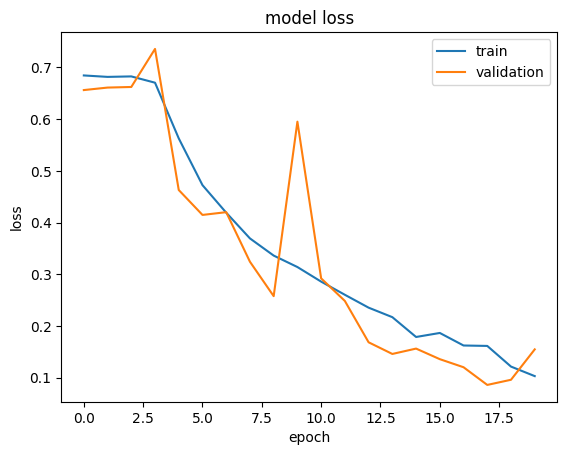

In [ ]:
# Visualization of loss in the model on training and validation data at different number of epochs
plt.plot(history_hf.history['loss'])
plt.plot(history_hf.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

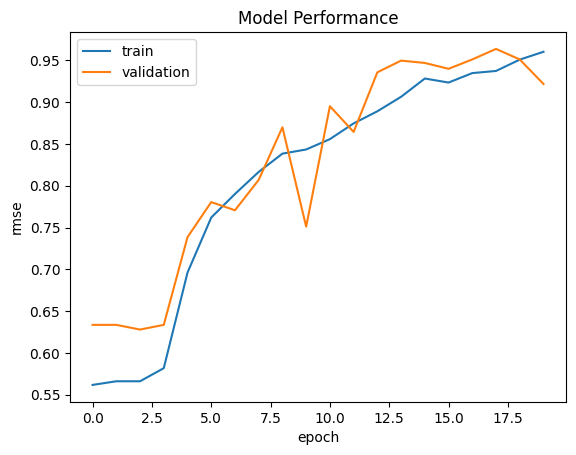

In [ ]:
# Visualization of performance of the model on training and validation data at different number of epochs
plt.plot(history_hf.history['accuracy'])
plt.plot(history_hf.history['val_accuracy'])

plt.title('Model Performance')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()


In [ ]:

#model evaluation
model.evaluate(validation_dataset)

23/23 [==============================] - 10s 431ms/step - loss: 0.1549 - accuracy: 0.9217


[0.1548612117767334, 0.9216783046722412]

**Confusion Matrix**

In [ ]:
predicted = []
true = []
for im, label in validation_dataset:
  predicted.append(model(im))
  true.append(label)

In [ ]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(),np.argmax(predicted[-1], axis = -1).flatten()])
true_label = np.concatenate([np.argmax(true[:-1], axis = -1).flatten(), np.argmax(true[-1], axis = -1).flatten()])


[[419  34]
 [ 22 240]]


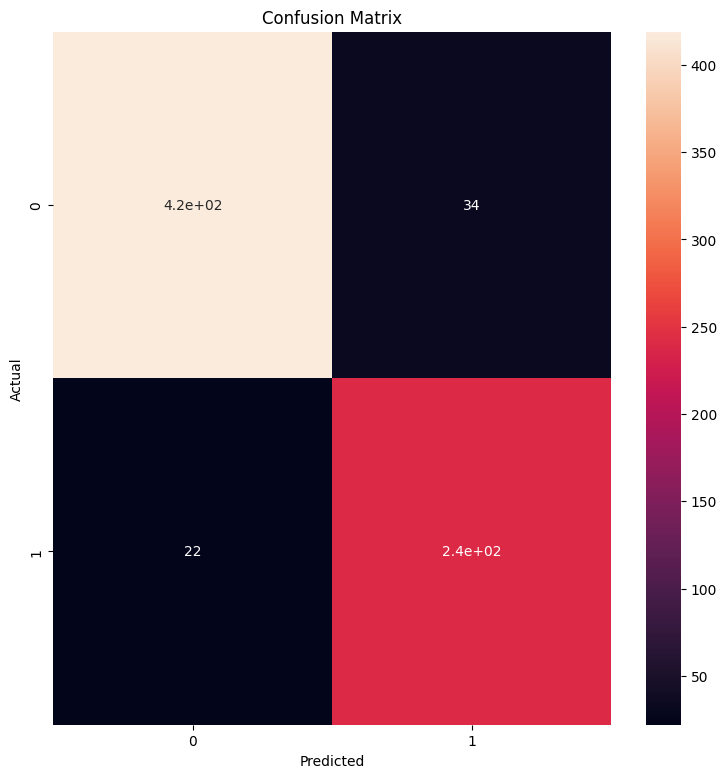

In [ ]:

cm = confusion_matrix(true_label,pred)
print(cm)
plt.figure(figsize = (9,9))
sns.heatmap(cm, annot = True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()